In [52]:
import json
import pandas as pd
import matplotlib
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

from sklearn.preprocessing import  StandardScaler
from sklearn.feature_selection import SelectKBest

from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import  RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import  GradientBoostingRegressor
import xgboost

# KDD

In [2]:
attributes = ['name', 'abv', 'ibu', 'target_fg',
              'target_og', 'ebc', 'srm', 'ph']

beer_df = pd.read_json('punk_ds.json')
beer_df = beer_df[attributes]
beer_df

,name,abv,ibu,target_fg,target_og,ebc,srm,ph
0,Buzz,4.5,60.0,1010.0,1044.0,20.0,10.0,4.4
1,Trashy Blonde,4.1,41.5,1010.0,1041.7,15.0,15.0,4.4
2,Berliner Weisse With Yuzu - B-Sides,4.2,8.0,1007.0,1040.0,8.0,4.0,3.2
3,Pilsen Lager,6.3,55.0,1012.0,1060.0,30.0,15.0,4.4
4,Avery Brown Dredge,7.2,59.0,1027.0,1069.0,10.0,5.0,4.4
...,...,...,...,...,...,...,...,...
320,Jinx Pale Ale,4.7,35.0,1008.0,1043.0,13.0,7.0,4.6
321,Jet Trash,6.9,65.0,1008.0,1060.0,18.0,9.0,4.6
322,Interstate Vienna Lager.,5.0,25.0,1007.0,1045.0,14.0,7.0,4.2
323,Fools Gold Dortmunder Lager,5.6,32.0,1009.0,1052.0,11.0,6.0,4.2


In [3]:
beer_df.dtypes

name          object
abv          float64
ibu          float64
target_fg    float64
target_og    float64
ebc          float64
srm          float64
ph           float64
dtype: object

In [4]:
beer_df[attributes].describe().T

,count,mean,std,min,25%,50%,75%,max
abv,325.0,7.906462,4.682521,0.5,5.200,7.2,9.0,55.0
ibu,320.0,65.243750,92.403699,0.0,35.000,50.0,70.0,1157.0
target_fg,324.0,1015.169753,14.488349,1000.0,1010.000,1012.0,1015.0,1125.0
target_og,324.0,1067.530556,27.142109,1007.0,1048.375,1065.0,1080.0,1157.0
ebc,319.0,66.228527,92.306210,2.0,15.000,28.0,70.5,600.0
srm,319.0,33.581881,46.505684,1.0,8.000,15.0,40.0,305.0
ph,323.0,4.641486,4.166788,3.2,4.400,4.4,4.4,79.0


<AxesSubplot:>

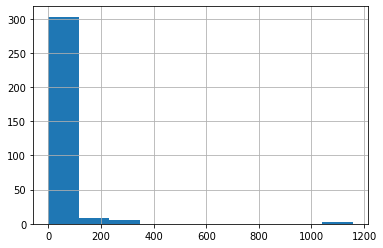

In [5]:
beer_df['ibu'].hist()

The ibu seems to have some outliers. Lets remove these using IQR.

In [6]:
Q1 = beer_df['ibu'].quantile(0.25)
Q3 = beer_df['ibu'].quantile(0.75)
IQR = Q3 - Q1

beer_df_no_outilier = beer_df[~((beer_df['ibu'] < (Q1 - 1.5 * IQR)) |
                                (beer_df['ibu'] > (Q3 + 1.5 * IQR)))]

print('Original dataset:', len(beer_df))
print('Dataset after outlier removal:', len(beer_df_no_outilier))

Original dataset: 325
Dataset after outlier removal: 308


<AxesSubplot:>

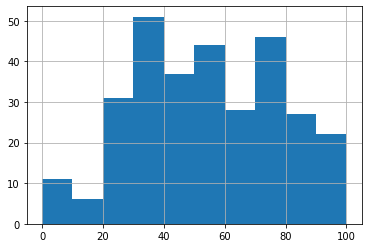

In [7]:
beer_df_no_outilier['ibu'].hist()

### Empty Values

In [8]:
beer_df_no_outilier.isna().sum()

name         0
abv          0
ibu          5
target_fg    1
target_og    1
ebc          6
srm          6
ph           1
dtype: int64

In [9]:
# Remove rows with empty IBU
beer_df_no_outilier = beer_df_no_outilier.dropna(subset=['ibu'])
beer_df_no_outilier.isna().sum()

name         0
abv          0
ibu          0
target_fg    0
target_og    0
ebc          4
srm          4
ph           0
dtype: int64

In [10]:
# TODO - investigate a better way to do that
beer_df_no_outilier['ebc'].fillna(0, inplace=True)
beer_df_no_outilier['srm'].fillna(0, inplace=True)
beer_df_no_outilier.isna().sum()

name         0
abv          0
ibu          0
target_fg    0
target_og    0
ebc          0
srm          0
ph           0
dtype: int64

# Train a ML Model to predict the IBU

In [11]:
# KFold Split
X_att = ['abv', 'target_fg', 'target_og', 'ebc', 'srm', 'ph']

X = beer_df_no_outilier[X_att].values
Y = beer_df_no_outilier['ibu'].values

### Train and Test Resgresssion Models

In [57]:
def predict_ipu(algorithm, X, Y):
    kf = KFold(n_splits=2, random_state=None, shuffle=True)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        # Train the model using the training sets
        algorithm.fit(X_train, Y_train)

        Y_pred = algorithm.predict(X_test)

        # The mean squared error
        print('Mean squared error: %.2f'
              % mean_squared_error(Y_test, Y_pred))
        # The coefficient of determination: 1 is perfect prediction
        print('Coefficient of determination: %.2f'
              % r2_score(Y_test, Y_pred))
        
#         for test, pred in zip(Y_test, Y_pred):
#             print(test, pred)
   
    print('\n')
    
predict_ipu(linear_model.LinearRegression(normalize=True), X, Y)

predict_ipu(KNeighborsRegressor(n_neighbors = 4), X, Y)

predict_ipu(GradientBoostingRegressor(), X, Y)

predict_ipu(RandomForestRegressor(), X, Y)

predict_ipu(xgboost.XGBRegressor(objective="reg:linear", random_state=42), X, Y)

Mean squared error: 470.23
Coefficient of determination: 0.13
Mean squared error: 8525.92
Coefficient of determination: -13.57


Mean squared error: 482.64
Coefficient of determination: 0.22
Mean squared error: 470.24
Coefficient of determination: 0.08


Mean squared error: 360.34
Coefficient of determination: 0.32
Mean squared error: 365.76
Coefficient of determination: 0.39


Mean squared error: 386.77
Coefficient of determination: 0.37
Mean squared error: 308.28
Coefficient of determination: 0.40


[19:54:18] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
Mean squared error: 491.14
Coefficient of determination: 0.10
[19:54:18] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
Mean squared error: 363.60
Coefficient of determination: 0.38




### Standardize Attributes

In [47]:
standardScale = StandardScaler()
standardScale.fit_transform(X)

selectkBest = SelectKBest(k=6)
X_new = selectkBest.fit_transform(X, Y)

In [50]:
# predict_ipu(linear_model.LinearRegression(normalize=True), X_new, Y)

# predict_ipu(KNeighborsRegressor(n_neighbors = 4), X_new, Y)

# predict_ipu(GradientBoostingRegressor(), X_new, Y)

predict_ipu(RandomForestRegressor(), X_new, Y)

Mean squared error: 452.58
Coefficient of determination: 0.26
60.0 43.0
41.5 46.61
8.0 18.85
55.0 54.5
38.0 28.97
35.0 55.27
40.0 34.47
30.0 62.82
75.0 65.66
30.0 62.93
42.0 44.22
45.0 62.23
70.0 49.87
70.0 66.55
55.0 34.0
40.0 79.05
35.0 38.28
8.0 15.69
85.0 62.05
70.0 69.9
70.0 64.82
100.0 82.6
20.5 57.29
50.0 79.15
70.0 70.17
20.0 31.49
55.0 70.03
35.0 44.13
70.0 69.9
100.0 98.85
30.0 46.73
65.0 37.59
68.0 75.56
85.0 83.15
55.0 44.36
50.0 85.27
35.0 46.59
85.0 82.05
35.0 50.99
80.0 68.75
80.0 77.65
35.0 43.58
60.0 66.15
70.0 67.95
77.0 77.8
45.0 47.32
40.0 39.37
20.0 83.65
20.0 43.79
60.0 50.23
45.0 76.4
85.0 53.21
42.0 57.11
40.0 34.57
85.0 48.98
30.0 42.6
20.0 21.33
42.0 56.21
50.0 75.2
40.0 63.09
35.0 67.22
32.0 50.05
60.0 46.44
65.0 56.97
90.0 60.26
40.0 26.16
67.0 61.51
20.0 27.59
67.0 61.51
40.0 46.25
50.0 43.38
90.0 81.75
80.0 56.0
35.0 37.38
85.0 80.25
75.0 67.95
35.0 38.21
50.0 80.09
25.0 52.16
65.0 46.56
40.0 55.7
25.0 28.66
36.0 36.78
50.0 55.51
100.0 68.25
30.0 34.19
80.